In [1]:
from keras.datasets import mnist
from keras.layers.merge import _Merge, multiply
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Embedding
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import signal
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from glob import glob
import math
from sklearn.model_selection import train_test_split
from PIL.ImageOps import invert
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from PIL import ImageDraw

np.random.seed(1234)
tf.set_random_seed(1234)

os.environ["CUDA_VISIBLE_DEVICES"]="0"


from keras.backend.tensorflow_backend import set_session 
config = tf.ConfigProto() 
config.gpu_options.per_process_gpu_memory_fraction = 0.1
config.gpu_options.allow_growth = True 
# dynamically grow the memory used on the GPU
config.log_device_placement = True # to log device placement (on which device the operation ran) 
# (nothing gets printed in Jupyter, only if you run it standalone) 
sess = tf.Session(config=config)
set_session(sess) # set this TensorFlow session as the default session for Keras

Using TensorFlow backend.


In [2]:

concrete_paths_stft = np.sort(glob('train-set/frequency/post/*_concrete_*_post.png'))
metallic_paths_stft = np.sort(glob('train-set/frequency/post/*_pec_*_post.png'))
plastic_paths_stft = np.sort(glob('train-set/frequency/post/*_pvc_*_post.png'))

concrete_paths = np.sort(glob('train-set/normal/post/*_concrete_*_post.png'))
metallic_paths = np.sort(glob('train-set/normal/post/*_pec_*_post.png'))
plastic_paths = np.sort(glob('train-set/normal/post/*_pvc_*_post.png'))

def load_img(path, stft=False):
    img = image.load_img(path,
                         color_mode='grayscale',
                         target_size=(256,256),
                         interpolation='hamming')
    if stft:
        img = invert(img)
    return image.img_to_array(img)

concrete_scans = np.array([load_img(path) for path in concrete_paths])
metallic_scans = np.array([load_img(path) for path in metallic_paths])
plastic_scans = np.array([load_img(path) for path in plastic_paths])

concrete_labels = np.zeros((len(concrete_scans),))
metallic_labels = np.ones((len(metallic_scans),))
plastic_labels = np.ones((len(plastic_scans),)) * 2

y = np.concatenate([concrete_labels, metallic_labels, plastic_labels]).astype(np.int32)
b_scans = np.concatenate([concrete_scans, metallic_scans, plastic_scans])
b_scans = (b_scans - 127.5) / 127.5

concrete_scans_stft = np.array([load_img(path, True) for path in concrete_paths_stft])
metallic_scans_stft = np.array([load_img(path, True) for path in metallic_paths_stft])
plastic_scans_stft = np.array([load_img(path, True) for path in plastic_paths_stft])

concrete_labels_stft = np.zeros((len(concrete_scans_stft),))
metallic_labels_stft = np.ones((len(metallic_scans_stft),))
plastic_labels_stft = np.ones((len(plastic_scans_stft),)) * 2

y_stft = np.concatenate(
    [concrete_labels_stft,
     metallic_labels_stft,
     plastic_labels_stft]).astype(np.int32)
b_scans_stft = np.concatenate([concrete_scans_stft, metallic_scans_stft, plastic_scans_stft])
b_scans_stft = (b_scans_stft - 127.5) / 127.5


print(concrete_scans.shape)
print(metallic_scans.shape)
print(plastic_scans.shape)

print(b_scans.shape)
                              
print(concrete_scans_stft.shape)
print(metallic_scans_stft.shape)
print(plastic_scans_stft.shape)

print(b_scans_stft.shape)

(522, 256, 256, 1)
(462, 256, 256, 1)
(450, 256, 256, 1)
(1434, 256, 256, 1)
(522, 256, 256, 1)
(462, 256, 256, 1)
(450, 256, 256, 1)
(1434, 256, 256, 1)


1


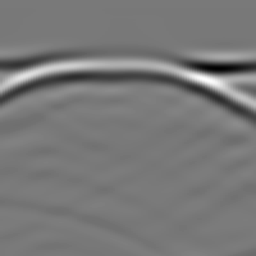

In [3]:
index = np.random.randint(0, len(b_scans))
img = image.array_to_img(b_scans[index])
print(y[index])
img

1


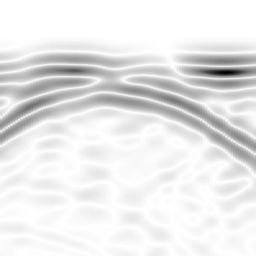

In [4]:
index = np.random.randint(0, len(b_scans_stft))
img = image.array_to_img(b_scans_stft[index])
print(y_stft[index])
img

In [5]:
X_train, X_test, y_train, y_test = train_test_split(b_scans, y)
X_train_stft, X_test_stft, y_train_stft, y_test_stft = train_test_split(b_scans_stft,
                                                                        y_stft)

In [6]:
def combined_classifier():
    normal_inputs = Input((256, 256, 1))
    stft_inputs = Input((256, 256, 1))
    model = Sequential()
    model.add(Conv2D(2, kernel_size=1, strides=2, padding="same", input_shape=(256, 256, 1)))
    model.add(LeakyReLU(alpha=0.3))
    model.add(Conv2D(4, kernel_size=1, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.3))
    
    
    stft_out = model(stft_inputs)
    normal_out = model(normal_inputs)
    
    out = multiply([stft_out, normal_out])
    out = Flatten()(out)
    out = Dense(3, activation='softmax')(out)
    return Model([normal_inputs, stft_inputs], out)
    


def build_classifier():
        model = Sequential()
        model.add(Conv2D(2, kernel_size=1, strides=2, padding="same", input_shape=(256, 256, 1)))
        model.add(LeakyReLU(alpha=0.3))  
        model.add(Conv2D(4, kernel_size=1, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.3))
        model.add(Flatten())
        model.add(Dense(3, activation='softmax'))
        return model
    
model_stft = combined_classifier()
model = build_classifier()
freq_model = build_classifier()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

freq_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
freq_model.summary()

model_stft.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_stft.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 2)       4         
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128, 128, 2)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 4)         12        
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64, 64, 4)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 49155     
Total params: 49,171
Trainable params: 49,171
Non-trainable params: 0


In [7]:

model.fit(X_train[:250],
          y_train[:250],
          epochs=30,
          validation_data=[X_test[:45], y_test[:45]])
model.save('aux_model_normal.h5')

Instructions for updating:
Use tf.cast instead.
Train on 250 samples, validate on 45 samples
Epoch 1/30


InternalError: Dst tensor is not initialized.
	 [[{{node _arg_conv2d_3_input_0_0}}]]
	 [[{{node metrics/acc/Mean}}]]

In [ ]:
freq_model.fit(X_train_stft[:250],
          y_train_stft[:250],
          epochs=30,
          validation_data = [X_test_stft[:45], y_test_stft[:45]])
freq_model.save('aux_model_freq.h5')

In [ ]:
from keras.callbacks import ModelCheckpoint

chkpt = ModelCheckpoint('aux_model_combined.h5', save_best_only=True)


model_stft.fit([X_train, X_train_stft],
               y_train,
               epochs=5,
               validation_data=[[X_test, X_test_stft],
                                 y_test],
               callbacks=[chkpt],
               verbose=0)

#model_stft.save('aux_model_combined.h5')

In [ ]:
y_pred = model.predict(X_test[:45])
clf_report = classification_report(y_test[:45],
                                   np.argmax(y_pred, axis=1),
                                   target_names=['concrete', 'metallic', 'plastic'])
print(clf_report)

cmat = confusion_matrix(y_test[:45], np.argmax(y_pred, axis=1))
print(cmat.diagonal()/cmat.sum(axis=1))

with open('normal_clf_report.txt', 'w') as f:
    f.write(clf_report)
    f.write(str(cmat))
    f.write(str(cmat.diagonal()/cmat.sum(axis=1)))
    f.write(str(model.summary()))

In [ ]:
annotations = []

for i in np.argmax(y_pred,1):
    if i == 0:
        annotations.append({'concrete': np.round(y_pred[i,:], decimals=2).max()})
    elif i == 1:
        annotations.append({'metallic': np.round(y_pred[i,:], decimals=2).max()})
    else:
        annotations.append({'pvc': np.round(y_pred[i,:], decimals=2).max()})

In [ ]:
y_pred = freq_model.predict(X_test_stft[:45])
clf_report = classification_report(y_test_stft[:45],
                                   np.argmax(y_pred, axis=1),
                                   target_names=['concrete', 'metallic', 'plastic'])
print(clf_report)

cmat = confusion_matrix(y_test[:45], np.argmax(y_pred, axis=1))
print(cmat.diagonal()/cmat.sum(axis=1))

with open('freq_clf_report.txt', 'w') as f:
    f.write(clf_report)
    f.write(str(cmat))
    f.write(str(cmat.diagonal()/cmat.sum(axis=1)))
    f.write(str(freq_model.summary()))

In [ ]:
annotations = []

for i in np.argmax(y_pred,1):
    if i == 0:
        annotations.append({'concrete': np.round(y_pred[i,:], decimals=2).max()})
    elif i == 1:
        annotations.append({'metallic': np.round(y_pred[i,:], decimals=2).max()})
    else:
        annotations.append({'pvc': np.round(y_pred[i,:], decimals=2).max()})
annotations

In [ ]:
y_pred = model_stft.predict([X_test[:45], X_test_stft[:45]])
clf_report = classification_report(y_test[:45], np.argmax(y_pred, axis=1), target_names=['concrete', 'metallic', 'plastic'])
print(clf_report)

cmat = confusion_matrix(y_test[:45], np.argmax(y_pred, axis=1))
print(cmat.diagonal()/cmat.sum(axis=1))

with open('combined_clf_report.txt', 'w') as f:
    f.write(clf_report)
    f.write(str(cmat))
    f.write(str(cmat.diagonal()/cmat.sum(axis=1)))
    f.write(str(model_stft.summary()))